In [1]:
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch
import numpy as np

import sys
import os
from ml_collections.config_dict import ConfigDict

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path + "/utils")

from utils.partialjaclib import *
from utils.vit import *
set_matplotlib_formats("pdf", "svg")

USE_GPU = True

dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif USE_GPU == True and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device("cpu")
print("using device:", device)


using device: mps


/var/folders/_k/d3_t098562j1mrxkzvt5b58h0000gn/T/ipykernel_95844/2982354033.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "svg")


In [2]:
config = ConfigDict()
config.data_scale = 1.0
config.batch_size = 32
config.channels = 3
config.image_size = 32

config.patch_size = 8
config.depth = 10
config.dim = 256
config.heads = 8
config.dim_head = config.dim // config.heads
config.hidden_dim = 4 * config.dim
config.num_classes = 10
config.dropout = 0.0
config.emb_dropout = 0.0
config.varw = 1.0
config.varb = 0.0
config.mu = 1.0
config.module_name = 'preln'
config.pool = 'cls'
modules = {'preln': PreLNBlock, 'postln': PostLNBlock, 'noln': NoLNBlock, 'preln_attn': PreLNAttnBlock, 'postln_attn': PostLNAttnBlock, 'noln_attn': NoLNAttnBlock}

In [7]:
xr = torch.normal(0, config.data_scale, (config.batch_size, config.channels, config.image_size, config.image_size)).to(device=device)
xr = Variable(xr, requires_grad=True)

wvars = np.arange(0.1, 4.11, 0.5)
# bvars = np.arange(0.0, 2.1, 0.2)
mus = np.arange(0.1, 1.01, 0.1)
chijs = np.zeros((len(modules), wvars.shape[0], mus.shape[0]))

n_proj = 2
n_ave = 1

for k, module_name in enumerate(modules.keys()):
    for _ in range(n_ave):
        for i in range(wvars.shape[0]):
            for j in range(mus.shape[0]):
                config.varw = wvars[i]
                config.mu = mus[j]
                config.module_name = module_name
                print(config.varw, config.mu, config.module_name)
                model = ViT(modules[config.module_name], config).to(device)
                fhook = fwd_hook_vit(model, modules[config.module_name], n = config.depth-2)
                bhook = bwd_hook_vit(model, modules[config.module_name], n = config.depth-3)
                out = model(xr)
                chijs[k, i, j] += partialj(fhook, bhook, n_proj, device)

chijs = chijs / n_ave

0.1 0.1 preln
0.1 0.2 preln
0.1 0.30000000000000004 preln
0.1 0.4 preln
0.1 0.5 preln
0.1 0.6 preln
0.1 0.7000000000000001 preln
0.1 0.8 preln
0.1 0.9 preln
0.1 1.0 preln
0.6 0.1 preln
0.6 0.2 preln
0.6 0.30000000000000004 preln
0.6 0.4 preln
0.6 0.5 preln
0.6 0.6 preln
0.6 0.7000000000000001 preln
0.6 0.8 preln
0.6 0.9 preln
0.6 1.0 preln
1.1 0.1 preln
1.1 0.2 preln
1.1 0.30000000000000004 preln
1.1 0.4 preln
1.1 0.5 preln
1.1 0.6 preln
1.1 0.7000000000000001 preln
1.1 0.8 preln
1.1 0.9 preln
1.1 1.0 preln
1.6 0.1 preln
1.6 0.2 preln
1.6 0.30000000000000004 preln
1.6 0.4 preln
1.6 0.5 preln
1.6 0.6 preln
1.6 0.7000000000000001 preln
1.6 0.8 preln
1.6 0.9 preln
1.6 1.0 preln
2.1 0.1 preln
2.1 0.2 preln
2.1 0.30000000000000004 preln
2.1 0.4 preln
2.1 0.5 preln
2.1 0.6 preln
2.1 0.7000000000000001 preln
2.1 0.8 preln
2.1 0.9 preln
2.1 1.0 preln
2.6 0.1 preln
2.6 0.2 preln
2.6 0.30000000000000004 preln
2.6 0.4 preln
2.6 0.5 preln
2.6 0.6 preln
2.6 0.7000000000000001 preln
2.6 0.8 preln
2.

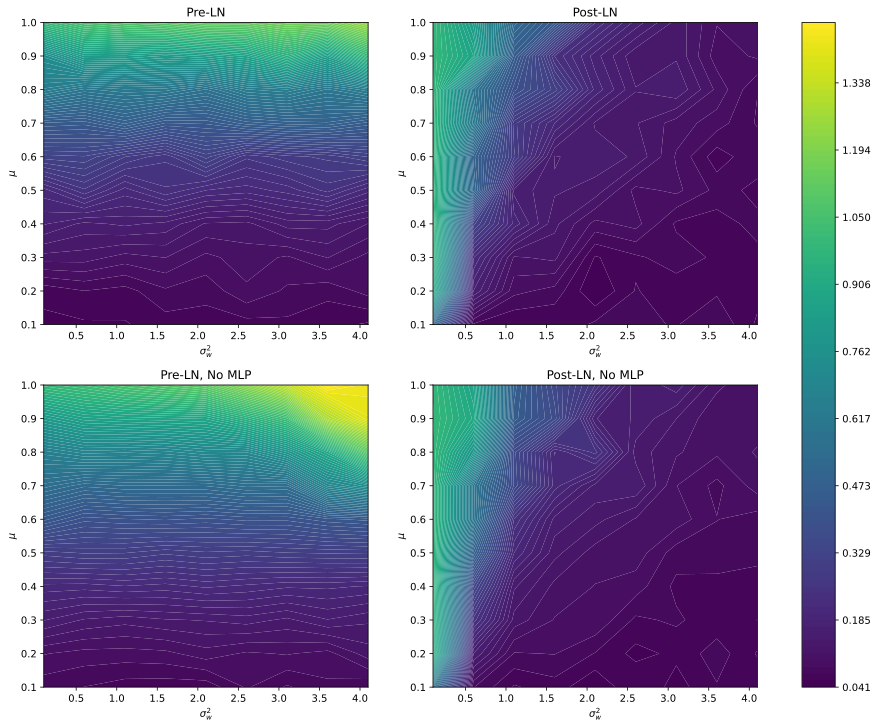

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (16, 12))
indices = [0, 1, 3, 4]
levels = np.linspace(chijs[indices,  :, :].min(), chijs[indices, :, :].max(), 100)
cf00 = axs[0, 0].contourf(wvars, mus, chijs[0].T, levels=levels)
axs[0, 0].set_title('Pre-LN')
cf01 = axs[0, 1].contourf(wvars, mus, chijs[1].T, levels=levels)
axs[0, 1].set_title('Post-LN')


cf10 = axs[1, 0].contourf(wvars, mus, chijs[3].T, levels=levels)
axs[1, 0].set_title('Pre-LN, No MLP')
cf11 = axs[1, 1].contourf(wvars, mus, chijs[4].T, levels=levels)
axs[1, 1].set_title('Post-LN, No MLP')


fig.colorbar(cf01, ax=axs)
for rows in axs:
    for ax in rows:
        ax.set_xlabel('$\\sigma_w^2$')
        ax.set_ylabel('$\\mu$')

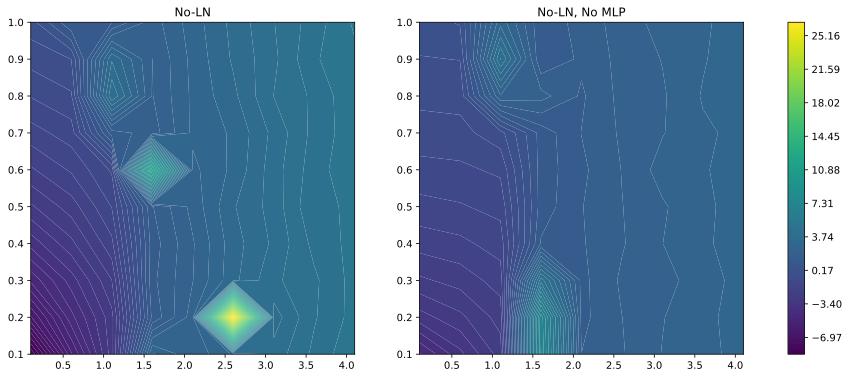

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (16, 6))
indices = [2, 5]
levels = np.linspace(np.log(chijs[indices,  :, :].min()), np.log(chijs[indices, :, :].max()), 100)
cf01 = axs[0].contourf(wvars, mus, np.log(chijs[2].T), levels = levels)
axs[0].set_title('No-LN')

cf02 = axs[1].contourf(wvars, mus, np.log(chijs[5].T), levels = levels)
axs[1].set_title('No-LN, No MLP')

fig.colorbar(cf01, ax=axs)
for ax in rows:
    ax.set_xlabel('$\\sigma_w^2$')
    ax.set_ylabel('$\\mu$')

In [10]:
xr = torch.normal(0, 5 * config.data_scale, (config.batch_size, config.channels, config.image_size, config.image_size)).to(device=device)
xr = Variable(xr, requires_grad=True)

wvars = np.arange(0.0, 4.1, 0.5)
# bvars = np.arange(0.0, 2.1, 0.2)
mus = np.arange(0.1, 1.01, 0.1)
chijs = np.zeros((len(modules), wvars.shape[0], mus.shape[0]))

n_proj = 2
n_ave = 3

for k, module_name in enumerate(modules.keys()):
    for _ in range(n_ave):
        for i in range(wvars.shape[0]):
            for j in range(mus.shape[0]):
                config.varw = wvars[i]
                config.mu = mus[j]
                config.module_name = module_name
                model = ViT(modules[config.module_name], config).to(device)
                fhook = fwd_hook_vit(model, modules[config.module_name], n = config.depth-2)
                bhook = bwd_hook_vit(model, modules[config.module_name], n = config.depth-3)
                out = model(xr)
                chijs[k, i, j] += partialj(fhook, bhook, n_proj, device)

chijs = chijs / n_ave

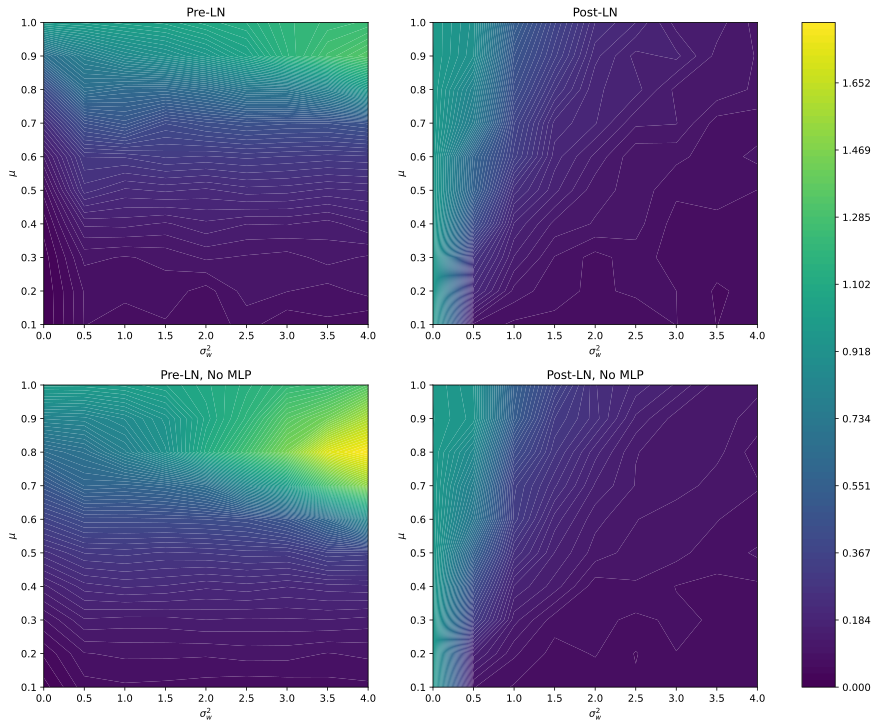

In [11]:
fig, axs = plt.subplots(2, 2, figsize = (16, 12))
indices = [0, 1, 3, 4]
levels = np.linspace(chijs[indices,  :, :].min(), chijs[indices, :, :].max(), 100)
cf00 = axs[0, 0].contourf(wvars, mus, chijs[0].T, levels=levels)
axs[0, 0].set_title('Pre-LN')
cf01 = axs[0, 1].contourf(wvars, mus, chijs[1].T, levels=levels)
axs[0, 1].set_title('Post-LN')


cf10 = axs[1, 0].contourf(wvars, mus, chijs[3].T, levels=levels)
axs[1, 0].set_title('Pre-LN, No MLP')
cf11 = axs[1, 1].contourf(wvars, mus, chijs[4].T, levels=levels)
axs[1, 1].set_title('Post-LN, No MLP')


fig.colorbar(cf01, ax=axs)
for rows in axs:
    for ax in rows:
        ax.set_xlabel('$\\sigma_w^2$')
        ax.set_ylabel('$\\mu$')

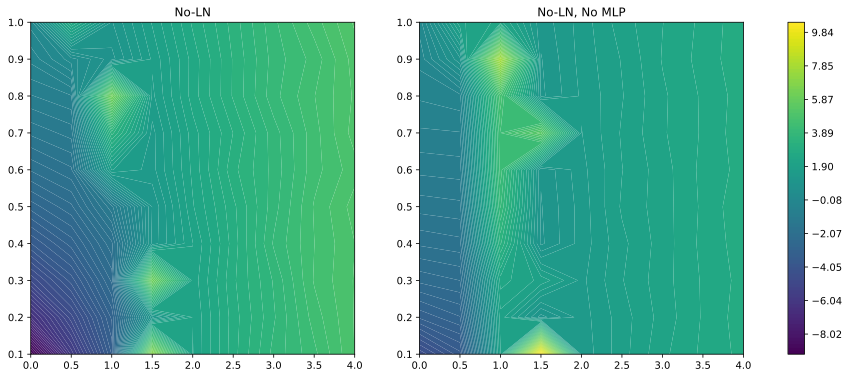

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (16, 6))
indices = [2, 5]
levels = np.linspace(np.log(chijs[indices,  :, :].min()), np.log(chijs[indices, :, :].max()), 100)
cf01 = axs[0].contourf(wvars, mus, np.log(chijs[2].T), levels = levels)
axs[0].set_title('No-LN')

cf02 = axs[1].contourf(wvars, mus, np.log(chijs[5].T), levels = levels)
axs[1].set_title('No-LN, No MLP')

fig.colorbar(cf01, ax=axs)
for ax in rows:
    ax.set_xlabel('$\\sigma_w^2$')
    ax.set_ylabel('$\\mu$')